In [1]:
import numpy as np
import csv
import io
from os import mkdir
import itertools
import json
import datetime
import pandas as pd 
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import lightgbm as lgb
import matplotlib.pyplot as plt
from util.plot_funcs import *
from random import uniform
from imblearn.over_sampling import RandomOverSampler
%load_ext autoreload
%autoreload 2
import warnings
import tensorflow.keras.backend as K
from sklearn import preprocessing
from IPython.display import SVG
from tensorflow.keras.models import Model
from keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import *
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
warnings.filterwarnings('ignore')

/Users/shiwang/Desktop/Personal/test_API/env/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


In [2]:
def show_model(model):
    return model_to_dot(model, show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg')

# Load processed data

In [103]:
%%time
with open('./processed_data/data.pickle', 'rb') as handle:
    data = pickle.load(handle)
train = data['train']
test = data['test']
all_test_sid = data['all_test_sid']

CPU times: user 1.02 s, sys: 1.09 s, total: 2.11 s
Wall time: 2.11 s


In [132]:
continuous_features = [
 'lon_diff',
 'lat_diff',
 'distance',
 'price',
 'eta',
 'O_lon',
 'O_lat',
 'D_lon',
 'D_lat',
 'num_plans',
 'eta_per_distance',
 'price_per_distance',
 'mode_hr_clicks',
 'mode_dow_clicks',
 'mode_rank_clicks',
 'eta_min', 
 'eta_max', 
 'distance_min', 
 'distance_max', 
 'price_max',
 'price_per_eta',
 'man_distance',
 'mode_mode_list_clicks',
 'is_night', 
 'is_weekend'
] 

In [133]:
discrete_features = [
    'dow',
    'hr',
    'transport_mode',
    'price_NA',
    'rank'
]

In [134]:
multi_features = [
 'profile'
 #'mode_list'
]

In [135]:
features_ = continuous_features + discrete_features + multi_features
print([x for x in features_ if x not in train.columns])
print([x for x in train.columns if x not in features_])

[]
['sid', 'pid', 'date', 'p0', 'p2', 'p3', 'p7', 'p8', 'p9', 'p10', 'p13', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p47', 'p54', 'p60', 'p62', 'p63', 'label', 'price_min', 'mode_list', 'weight']


In [108]:
profile_cols = ['p'+str(x) for x in range(66) if 'p'+str(x) in train.columns]
for idx, col in zip(range(len(profile_cols)), profile_cols):
    train[col] = train[col].apply(lambda x: idx + 1 if x == 1 else 0)
    test[col]  = test[col].apply(lambda x: idx + 1 if x == 1 else 0)

In [109]:
train['profile'] = train[profile_cols].values.tolist()
test['profile']  = test[profile_cols].values.tolist()
train['profile'] = train['profile'].apply(lambda x:[xx for xx in x if xx != 0])
test['profile']  = test['profile'].apply(lambda x:[xx for xx in x if xx != 0])

In [127]:
L_con = len(continuous_features)
print('There is a total of', L_con, 'Continuous features.')
L_dis = len(discrete_features)
print('There is a total of', L_dis , 'Single-Level categorical features.')
L_mul = len(multi_features)
print('There is a total of', L_dis , 'Multiple-Level categorical features.')

There is a total of 25 Continuous features.
There is a total of 5 Single-Level categorical features.
There is a total of 5 Multiple-Level categorical features.


In [128]:
dis_feature_dim = {}
le = preprocessing.LabelEncoder()
for feature in discrete_features:
    le.fit(train[feature])
    train[feature] = le.transform(train[feature])
    test[feature] = le.transform(test[feature])
    leng = len(set(train[feature]))
    max_num = max(train[feature])
    min_num = min(train[feature])
    dis_feature_dim[feature] = leng 
    print(feature, min_num, max_num, leng)

dow 0 6 7
hr 0 23 24
transport_mode 0 10 11
price_NA 0 1 2
rank 0 6 7


In [129]:
mul_feature_dim = {}
for feature in multi_features:
    max_num = 1
    min_num = 1
    for x in train[feature]:
        for xx in x:
            max_num = max(max_num, xx)
            min_num = min(min_num, xx)
    leng = max_num
    mul_feature_dim[feature] = leng + 1
    train[feature] = list(pad_sequences(train[feature], maxlen = max_num, padding='post', value = 0))
    test[feature]  = list(pad_sequences(test[feature],  maxlen = max_num, padding='post', value = 0))
    print(feature, min_num, max_num, leng)

profile 0 26 26


In [130]:
%%time
data = {'train': train, 'test':test}
with open('./processed_data/data_fm.pickle', 'wb') as handle:
    pickle.dump(data, handle)

CPU times: user 13.4 s, sys: 1.9 s, total: 15.3 s
Wall time: 15.5 s


In [131]:
%%time
with open('./processed_data/data_fm.pickle', 'rb') as handle:
    data = pickle.load(handle)

train = data['train']
test = data['test']

CPU times: user 4.65 s, sys: 1.56 s, total: 6.21 s
Wall time: 6.21 s


In [136]:
train_ = train[train['num_plans'] > 1].fillna(0)
test_ = test.copy()

In [137]:
for col in continuous_features:
    data = pd.concat([train_[col], test_[col]])
    data = data[(data < data.quantile(.95)) & (data > data.quantile(.05))]
    mean_ = data.mean()
    std_  = data.std()
    train_[col] = (train_[col] - mean_) / std_
    train_[col] = np.minimum(2.5, train_[col])
    train_[col] = np.maximum(-2.5, train_[col])
    test_[col]  = (test_[col]  - mean_) / std_
    test_[col] = np.minimum(2.5, test_[col])
    test_[col] = np.maximum(-2.5, test_[col])
    print(col, mean_, std_)

lon_diff 0.0014554203205879215 0.08002415190658232
lat_diff -0.0008543644715982937 0.06526621826173815
distance 14889.123787252118 10898.257371892982
price 1546.2471977282917 1706.419129023922
eta 2690.9265912051715 1406.1018457956172
O_lon 116.38485419408488 0.07284178768150774
O_lat 39.93695292210555 0.0628241779241549
D_lon 116.38360532354503 0.07341200940018383
D_lat 39.93642545876878 0.061647867320551816
num_plans 4.586909233009864 0.49238901987619066
eta_per_distance 1.0581201790680492 0.32123902702687707
price_per_distance 1.2932142404992912 0.8974260346598989
mode_hr_clicks 0.20433944112372968 0.18548773530679485
mode_dow_clicks 0.206085030038208 0.18310442455804654
mode_rank_clicks 0.1868545378618458 0.25009330543057057
eta_min 301420.8133450776 340835.31080397073
eta_max 0.6932276204670985 0.2358243204189502
distance_min 1.1088590363801936 0.13891700588210154
distance_max 0.8946988779961487 0.11235145609326667
price_max 0.3067521201596811 0.3950047776634666
price_per_eta 1.17

In [181]:
temp = pd.DataFrame(train_[(train_['label'] == 1)]['transport_mode'].value_counts()).reset_index().sort_values(by = 'index')
temp.columns = ['transport_mode', 'weight']
temp['weight'] = np.sqrt(1 / temp['weight'] * 10000)
base_weights = temp

if 'weight' in train_.columns:
    del train_['weight']
adjusts = [1, 1, 3, 2, 1, 1.5, 2, 1, 3, 1.5, 1]
weights = base_weights.copy()
for idx, adjust in zip(range(1,12), adjusts):
    weights.loc[weights['transport_mode'] == idx, 'weight'] = \
    weights.loc[weights['transport_mode'] == idx, 'weight'] * adjust

weights['label'] = 1
train_ = train_.merge(weights, on = ['transport_mode','label'], how = 'left')
train_['weight'] = train_['weight'].fillna(1)

In [182]:
sid_train = list(set(train_[(train_['date'] <  datetime.date(2018, 11, 24)) & \
                            (train_['date'] >  datetime.date(2018, 10, 7))]['sid']))
sid_eval  = list(set(train_[train_['date'] >= datetime.date(2018, 11, 24)]['sid']))

In [406]:
sid_train, sid_eval = train_test_split(list(set(train_['sid'])), test_size=0.15, random_state=88)

In [183]:
X_train = train_[train_['sid'].isin(sid_train)]
X_eval  = train_[train_['sid'].isin(sid_eval)]
y_train = train_[train_['sid'].isin(sid_train)]['label']
y_eval  = train_[train_['sid'].isin(sid_eval)]['label']

In [184]:
X_train_ = [list(X_train[col][:-1]) for col in features_]
X_eval_  = [list(X_eval[col])  for col in features_]
y_train_ = y_train[:-1]
y_eval_  = y_eval
X_test_  = [list(test_[col]) for col in features_]
weights  = X_train['weight'][:-1]

# Define Network

<img src="./figure/deepfm.png" width="600">

## Define 1st order Factorization Machine layer

Embed all features into K dimension

In [185]:
KK = 1

In [186]:
fea_num_1ds = []
for feature in continuous_features:
    fea_num_1ds.append(Input((1,), name = 'input_con_1d_' + feature))

In [187]:
fea_dis_1ds = []
for feature in discrete_features:
    fea_dis_1ds.append(Input((1,), name = 'input_dis_1d_' + feature))

In [188]:
fea_mul_1ds = []
for feature in multi_features:
    dim = mul_feature_dim[feature]
    fea_mul_1ds.append(Input((dim - 1,), name = 'input_mul_1d_' + feature))

In [189]:
inputs = fea_num_1ds + fea_dis_1ds + fea_mul_1ds

In [190]:
num_dense_1ds = []
for feature, fea_num_1d in zip(continuous_features, fea_num_1ds):
    num_dense_1ds.append(Dense(KK, name = 'num_dense_1d_'+ feature)(fea_num_1d))

In [191]:
dis_embed_1ds = []
for feature, fea_dis_1d in zip(discrete_features, fea_dis_1ds):
    dim = dis_feature_dim[feature]
    dis_embed_1ds.append(Embedding(dim, KK, name = 'dis_embed_1d_' + feature)(fea_dis_1d))

In [192]:
dis_embed_1ds = [Reshape((KK,))(i) for i in dis_embed_1ds]

In [193]:
mul_embed_1ds = []
for feature, fea_mul_1d in zip(multi_features, fea_mul_1ds):
    dim = mul_feature_dim[feature]
    mul_embed_1ds.append(Embedding(dim, KK, mask_zero = True, name = 'mul_embed_1d_' + feature)(fea_mul_1d))

In [194]:
def Tensor_Mean_Pooling(keepdims = False):
    return Lambda(lambda x: K.mean(x, axis = 1, keepdims=keepdims))

In [195]:
mul_embed_1ds = [Tensor_Mean_Pooling()(i) for i in mul_embed_1ds]

In [196]:
y_fm_1d = Add(name = 'fm_1d_output')(num_dense_1ds + dis_embed_1ds + mul_embed_1ds)

In [197]:
fm_model_1d = Model(inputs, y_fm_1d)
#SVG(show_model(fm_model_1d))

## Define 2nd order Factorization Machine layer

Embed all features into K dimension

In [198]:
KK = 10

In [199]:
num_dense_2ds = []
for feature, fea_num_1d in zip(continuous_features, fea_num_1ds):
    num_dense_2ds.append(Dense(KK, name = 'num_dense_2d_'+ feature)(fea_num_1d))

In [200]:
num_dense_2ds = [Reshape((1, KK))(i) for i in num_dense_2ds]

In [201]:
dis_embed_2ds = []
for feature, fea_dis_1d in zip(discrete_features, fea_dis_1ds):
    dim = dis_feature_dim[feature]
    dis_embed_2ds.append(Embedding(dim, KK, name = 'dis_embed_2d_' + feature)(fea_dis_1d))

In [202]:
mul_embed_2ds = []
for feature, fea_mul_1d in zip(multi_features, fea_mul_1ds):
    dim = mul_feature_dim[feature]
    mul_embed_2ds.append(Embedding(dim, KK, name = 'mul_embed_2d_' + feature)(fea_mul_1d))

In [203]:
mul_embed_2ds = [Tensor_Mean_Pooling(keepdims = True)(i) for i in mul_embed_2ds]

In [204]:
embed_2ds = num_dense_2ds + dis_embed_2ds + mul_embed_2ds
embed_2ds_concat = Concatenate(axis=1, name = 'embed_2ds_concat')(embed_2ds)
flat_2ds = [Flatten()(i) for i in embed_2ds]

***To be simplified***

In [205]:
fm_layers_2ds = []
for emb1,emb2 in itertools.combinations(flat_2ds, 2):
    fm_layers_2ds.append(dot([emb1,emb2], axes = 1, normalize=False))

In [206]:
y_fm_2d = Add()(fm_layers_2ds)

In [207]:
y_fm_2d.shape

TensorShape([Dimension(None), Dimension(1)])

In [208]:
fm_model_2d = Model(inputs, y_fm_2d)
#SVG(show_model(fm_model_2d))

## Define Deep NN layers

In [209]:
flat_embed_2d = Flatten(name = 'flat_embed_2ds')(embed_2ds_concat)

In [210]:
dropout = 0.5

In [211]:
dnn_layer_dims = [128,64, 32]
y_dnn = flat_embed_2d
for dim in dnn_layer_dims:
    y_dnn = Dropout(dropout)(y_dnn)
    y_dnn = Dense(dim, activation='relu')(y_dnn)

In [212]:
dnn_output = Dense(1, activation='relu', name = 'dnn_output')(y_dnn)

In [213]:
deep_model = Model(inputs, dnn_output)
#SVG(show_model(deep_model))

## Merge all layers

In [214]:
y = Concatenate()([y_fm_1d, y_fm_2d, dnn_output])
y_output = Dense(1, activation='sigmoid',name = 'deepfm_output')(y)

In [215]:
deepfm_model = Model(inputs, y_output)
#SVG(show_model(deepfm_model))

In [63]:
plot_model(deepfm_model, to_file='./figure/model.png', show_shapes=True)

# Train Model

In [216]:
epochs = 3
batch_size = 2048

In [217]:
deepfm_model.compile(loss = 'binary_crossentropy', optimizer = 'adam')

In [218]:
# 0.32
train_history = deepfm_model.fit( X_train_, 
                                  y_train_, 
                                  epochs = epochs, 
                                  batch_size = batch_size, 
                                  validation_data = (X_eval_, y_eval_),
                                  sample_weight = np.array(weights),
                                  shuffle = True)

Train on 1482563 samples, validate on 221774 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
1482563/1482563 [==============================] - 89s 60us/sample - loss: nan - val_loss: nan
Epoch 2/3
1482563/1482563 [==============================] - 65s 44us/sample - loss: nan - val_loss: nan
Epoch 3/3
1482563/1482563 [==============================] - 63s 42us/sample - loss: nan - val_loss: nan



# Apply to validation set

In [770]:
# copied
def get_best_mode_dt(gp):
    result = [(x, y) for x, y in zip(gp['transport_mode'], gp['pred_prob'])]
    result.sort(key = lambda x: x[1], reverse = True)
    return result[0][0]

In [771]:
def get_predictions_deepfm(df, deepfm_model, X):
    pred = deepfm_model.predict(X, batch_size = 1024)
    pred = [x[0] for x in pred]
    df['pred_prob'] = pred
    output = pd.DataFrame(df.groupby('sid').apply(get_best_mode_dt)).reset_index()
    output.columns = ['sid', 'recommend_mode']
    output['recommend_mode'] = output['recommend_mode'] + 1
    return df, output 

In [772]:
%%time
X_eval, output = get_predictions_deepfm(X_eval, deepfm_model, X_eval_)

CPU times: user 1min 4s, sys: 16.3 s, total: 1min 20s
Wall time: 1min 26s


0.6254288386409234


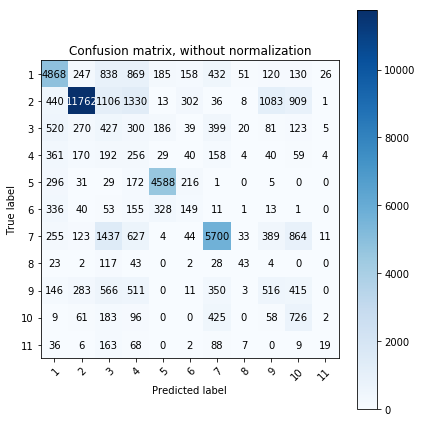

In [773]:
# copied
eval_true = X_eval[X_eval['label'] == 1][['sid','transport_mode']]
eval_true['transport_mode'] = eval_true['transport_mode'] + 1
eval_true.columns = ['sid','true']
output.columns = ['sid', 'pred']
eval_sum = eval_true.merge(output, on = 'sid')
weight_f1 = f1_score(eval_sum['true'], eval_sum['pred'], average = 'weighted')
print(weight_f1) #0.745, 0.747
plot_confusion_matrix_(eval_sum['true'], eval_sum['pred'], classes=list(range(1,12)))

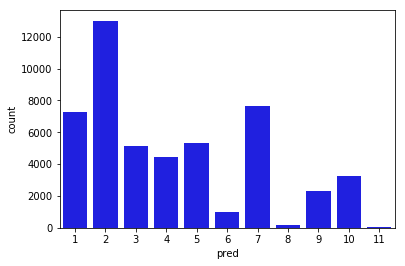

In [774]:
sns.countplot(output['pred'], color = 'blue')

# Apply to test set

In [716]:
%%time
test_, output = get_predictions_deepfm(test_, deepfm_model, X_test_)

CPU times: user 37.7 s, sys: 3.07 s, total: 40.8 s
Wall time: 33.2 s


**Fill no-plan sessions with zeros**

In [717]:
set_1 = all_test_sid
set_2 = set(test['sid'])
no_click_sids = [x for x in set_1 if x not in set_2]
temp = pd.DataFrame({'sid': no_click_sids, 'recommend_mode':0})
output = pd.concat([output, temp], axis = 0, ignore_index=True)

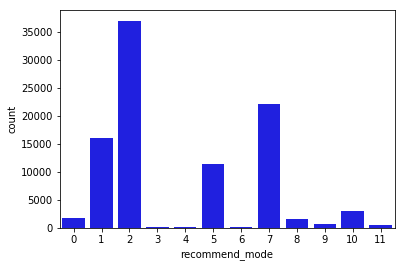

In [718]:
sns.countplot(output['recommend_mode'], color = 'blue')

**Export csv**

In [661]:
time_ = str(datetime.datetime.now())
mkdir('./submission/' + time_)

In [662]:
output['sid'] = output['sid'].astype(str)
output['recommend_mode'] = output['recommend_mode'].astype(str)
output.to_csv('./submission/' + time_ + '/submission.csv', index = False, quoting = csv.QUOTE_NONNUMERIC)